In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
### 시각화를 위한 라이브러리
# - 파이썬 시각화에서 가장 기본적인 시각화 라이브러리
import matplotlib.pyplot as plt

### 한글처리
from matplotlib import font_manager, rc

### 운영체제 확인 라이브러리
import platform

### 시각화 시 마이너스(-, 음수) 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

### OS별 한글처리
# - 윈도우 운영체게
if platform.system() == "Windows" :
    # path = "c:/Windows/Fonts/malgun.ttf"
    # font_name = font_manager.FontProperties(fname=path).get_name()
    # rc("font", family = font_name)
    
    ### 또는 아래처럼 한줄로도 가능 (아래 한글처리를 주로 사용합니다.)
    plt.rc("font", family = "Malgun Gothic")

# - Mac 운영체제
elif platform.system() == "Darwin" :
    rc("font", family = "AppleGothic")
    
else :
    print("넌 누구?")

In [4]:
labeled = pd.read_csv("./25day/data/labeled_data.csv")
labeled_cn7 = labeled[(labeled["PART_NAME"] == "CN7 W/S SIDE MLD'G RH") |(labeled["PART_NAME"] == "CN7 W/S SIDE MLD'G LH")]
labeled_cn7 = labeled_cn7.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "Reason", "PART_FACT_SERIAL", "PART_NAME",
               "EQUIP_NAME", "EQUIP_CD", "Switch_Over_Position", "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5",
                "Mold_Temperature_6", "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
               "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7"])
labeled_cn7

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,Y,9.59,4.47,16.920000,59.520000,7.13,653.409973,68.849998,647.98999,55.400002,...,59.299999,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,66.300003,24.799999,27.500000
1,Y,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
2,Y,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
3,Y,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
4,Y,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,Y,9.60,4.48,16.620001,59.560001,7.11,653.429993,68.330002,647.98999,54.900002,...,59.900002,276.500000,274.899994,275.100006,269.500000,255.600006,229.600006,66.099998,21.000000,22.400000
7992,Y,9.60,4.48,16.650000,59.560001,7.11,653.429993,68.349998,647.98999,55.000000,...,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7993,Y,9.60,4.48,16.650000,59.560001,7.11,653.429993,68.349998,647.98999,55.000000,...,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7994,Y,9.60,4.48,16.629999,59.580002,7.11,653.429993,68.330002,647.98999,54.900002,...,59.900002,276.100006,275.799988,275.000000,271.299988,255.100006,230.199997,65.199997,21.000000,22.299999


In [5]:
labeled_cn7["PassOrFail"] = labeled_cn7["PassOrFail"].replace('Y',1).replace('N',0)
### Clamp_Open_Position에서 눈에띄게 낮은 값들 제거
cn7 = labeled_cn7[labeled_cn7["Clamp_Open_Position"]>=200] 
cn7 = cn7.drop(columns=["Clamp_Open_Position"])

C:\Users\Admin\AppData\Local\Temp\ipykernel_8732\1946031374.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labeled_cn7["PassOrFail"] = labeled_cn7["PassOrFail"].replace('Y',1).replace('N',0)


In [6]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

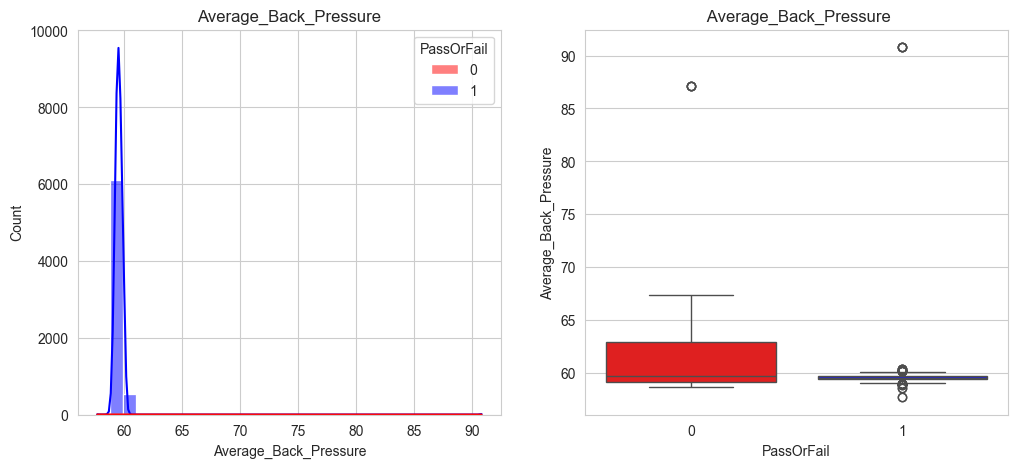

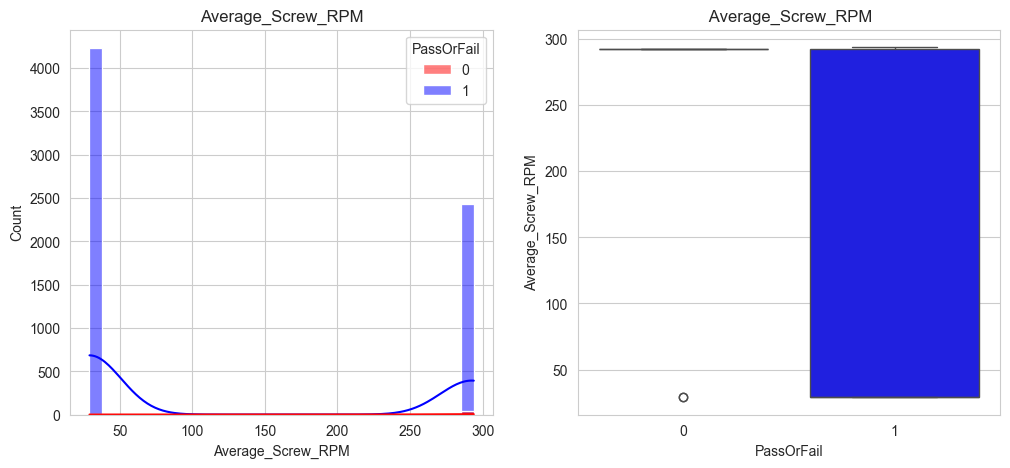

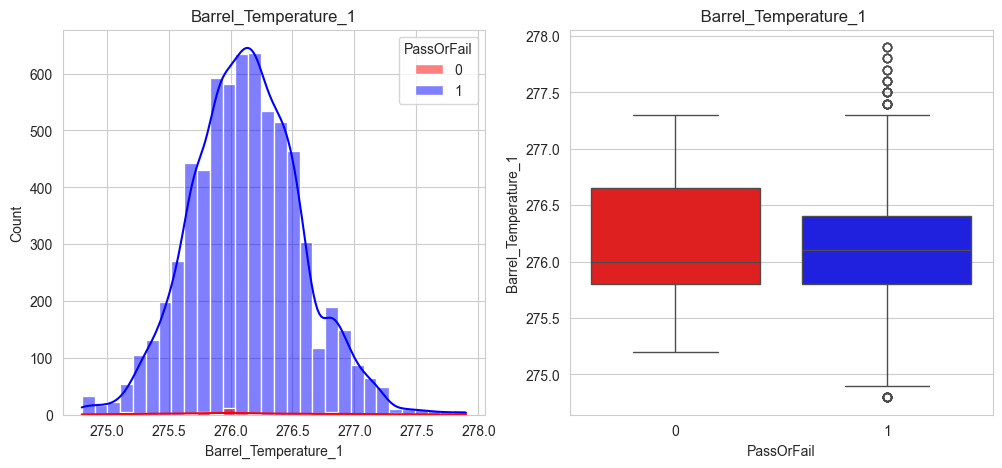

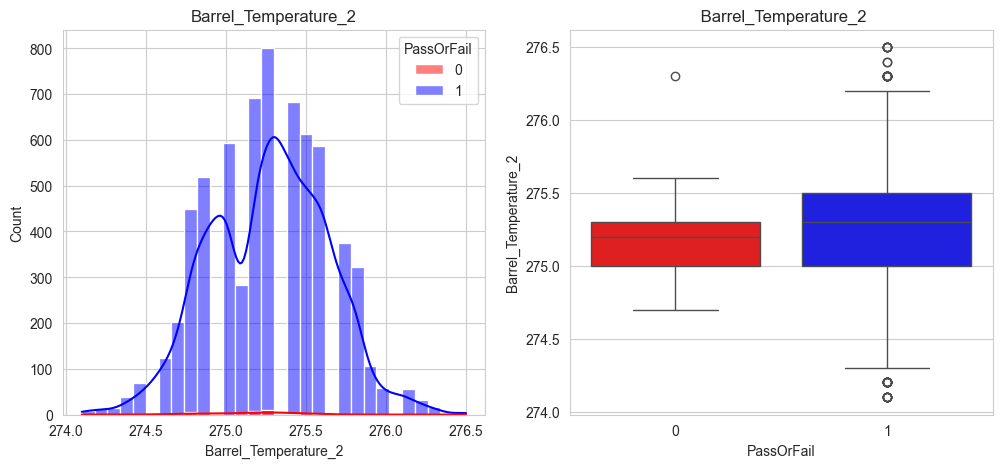

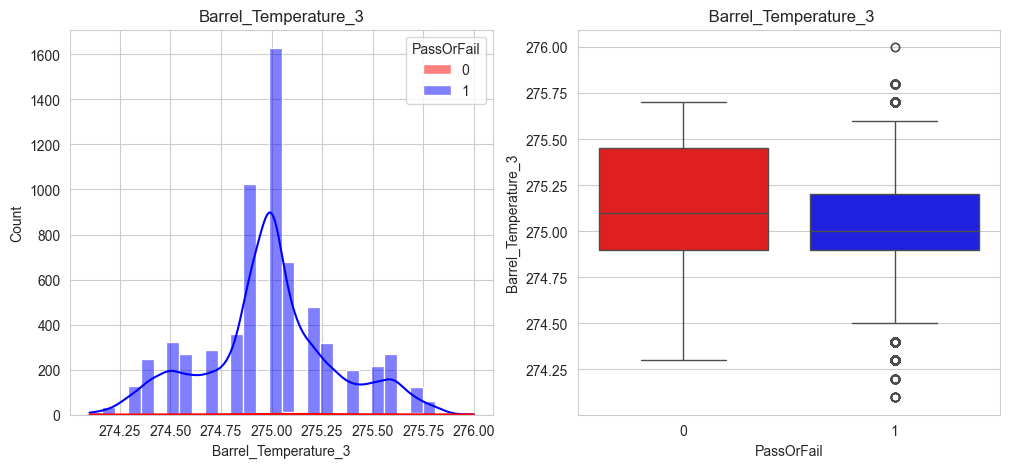

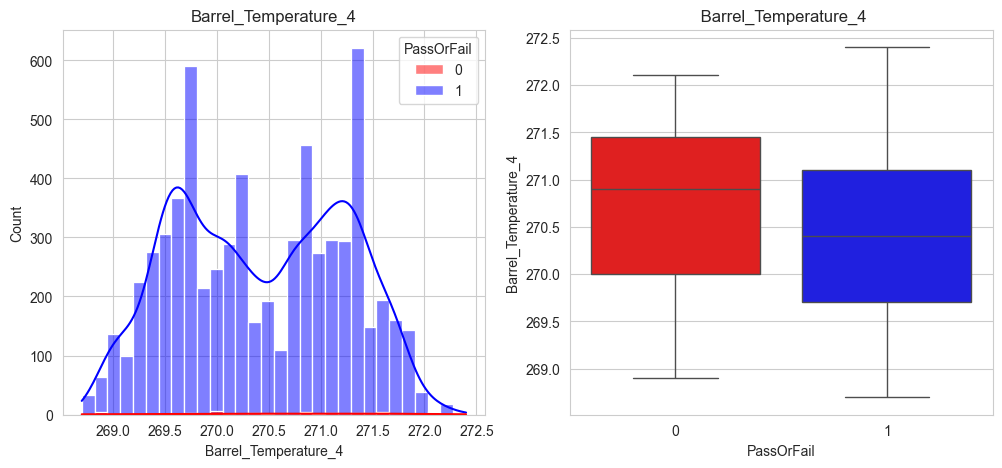

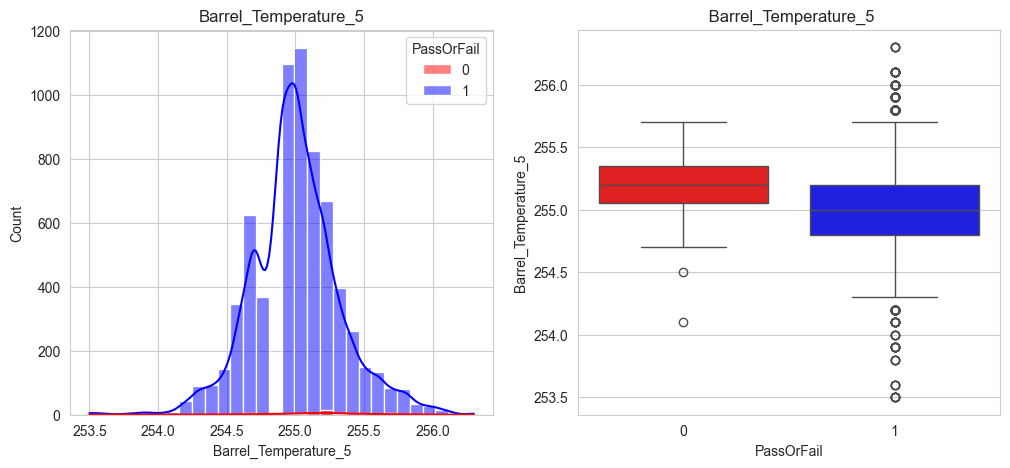

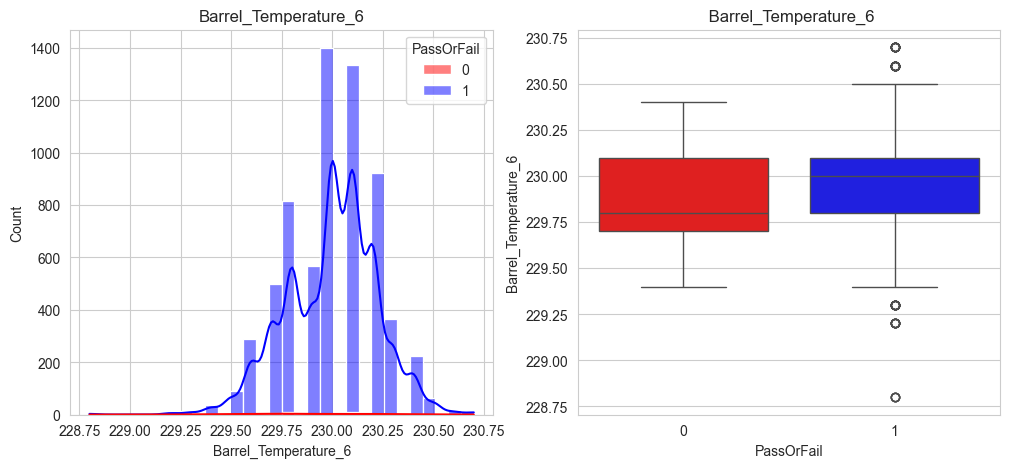

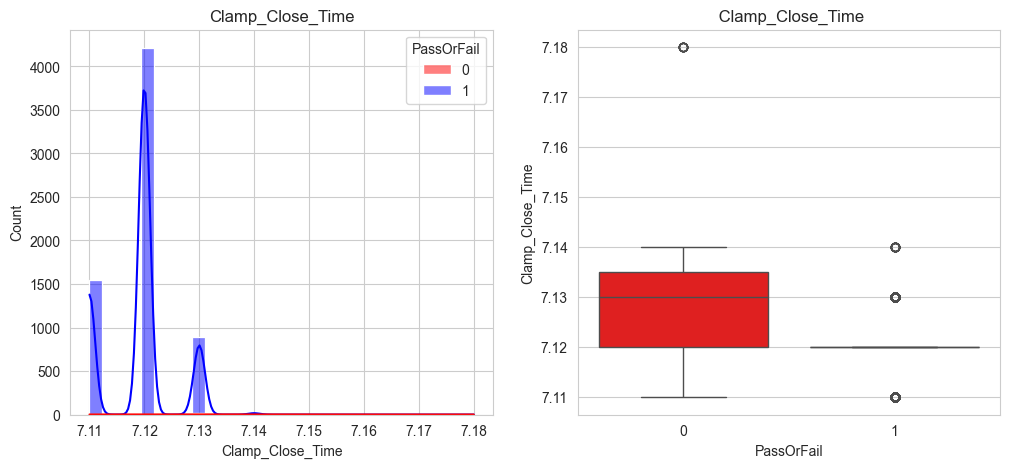

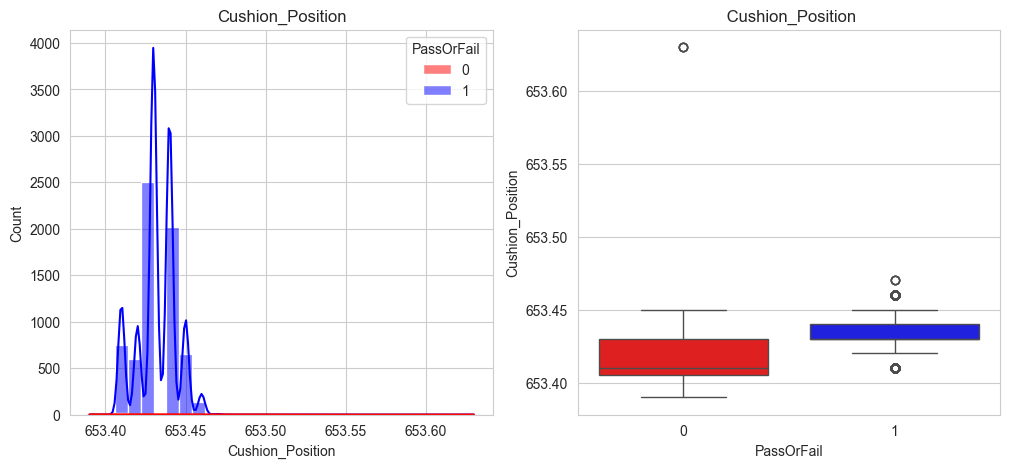

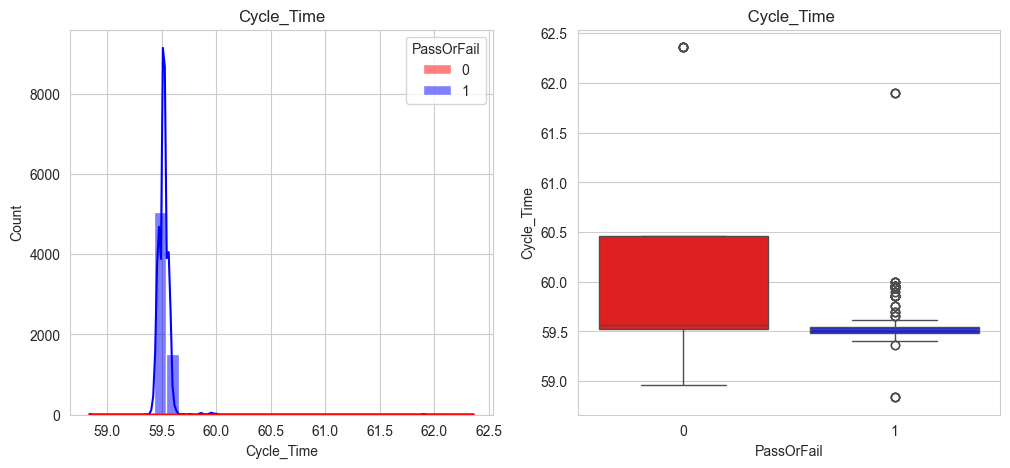

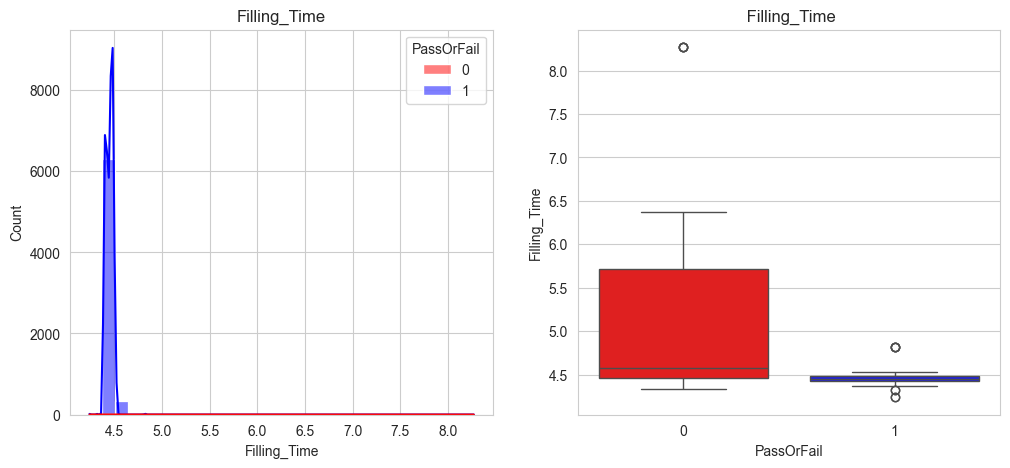

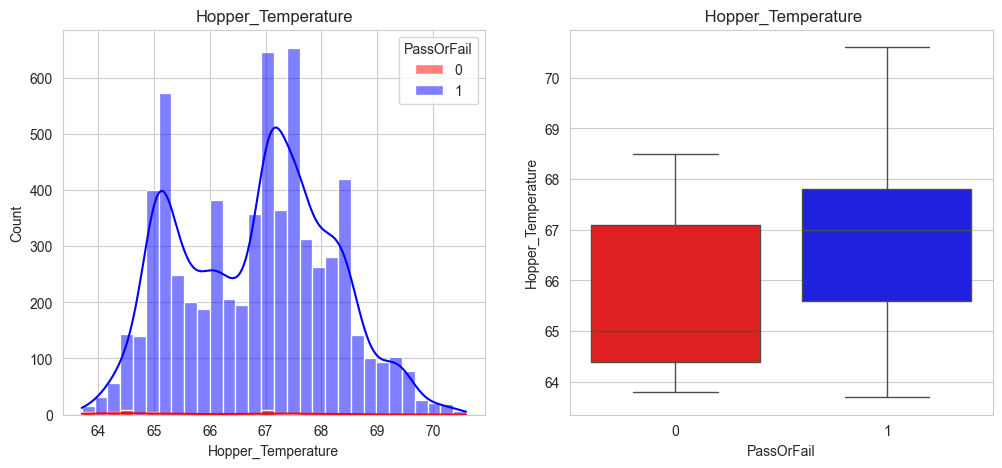

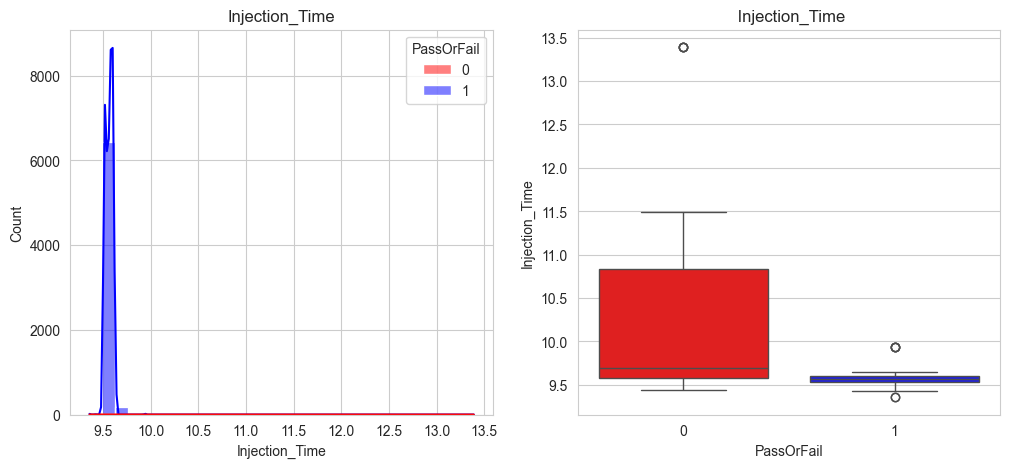

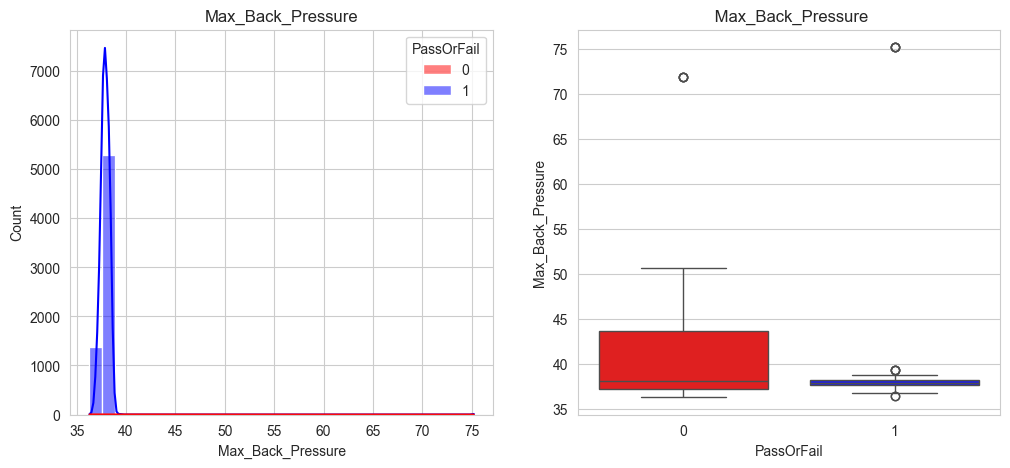

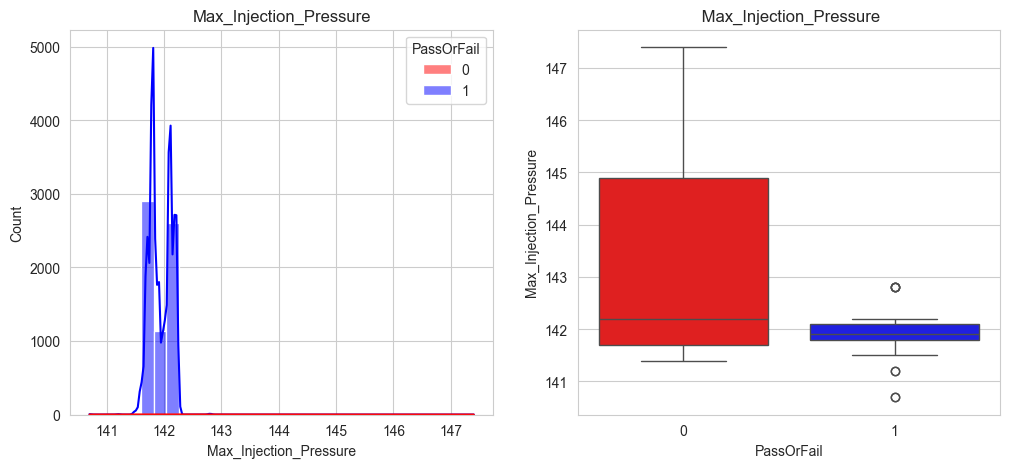

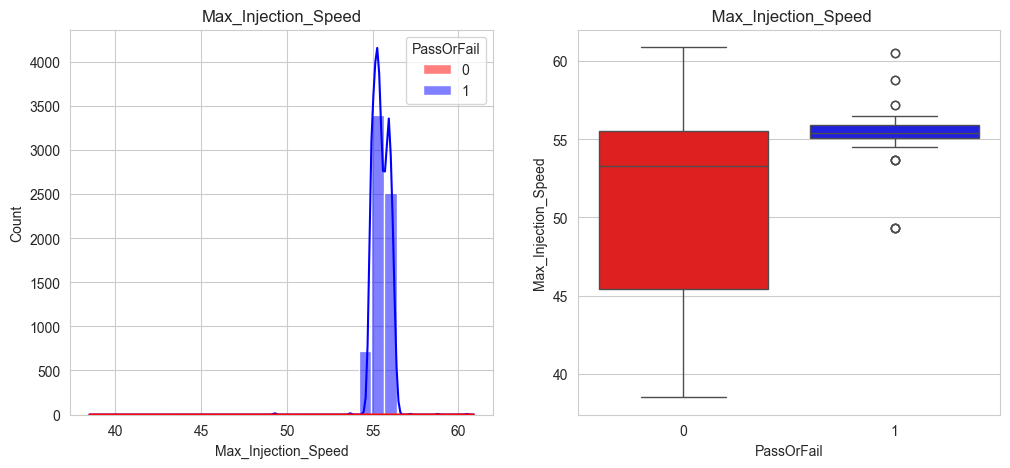

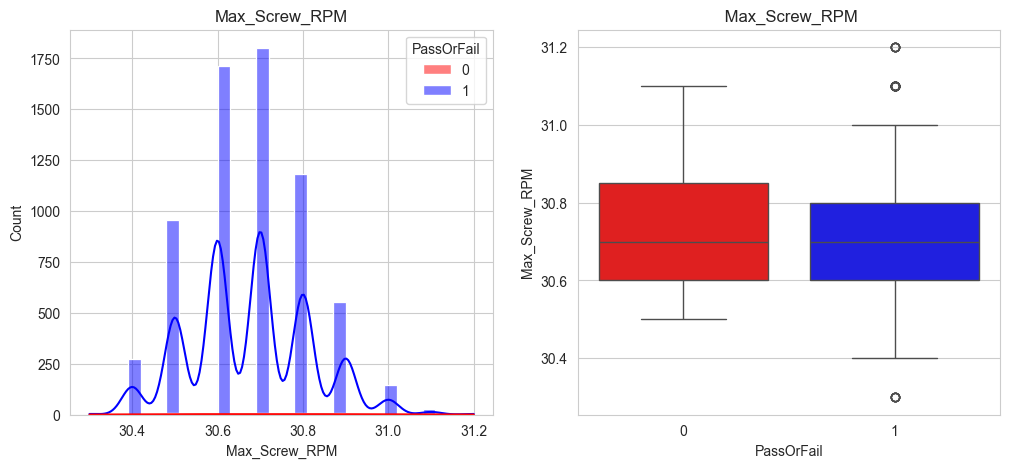

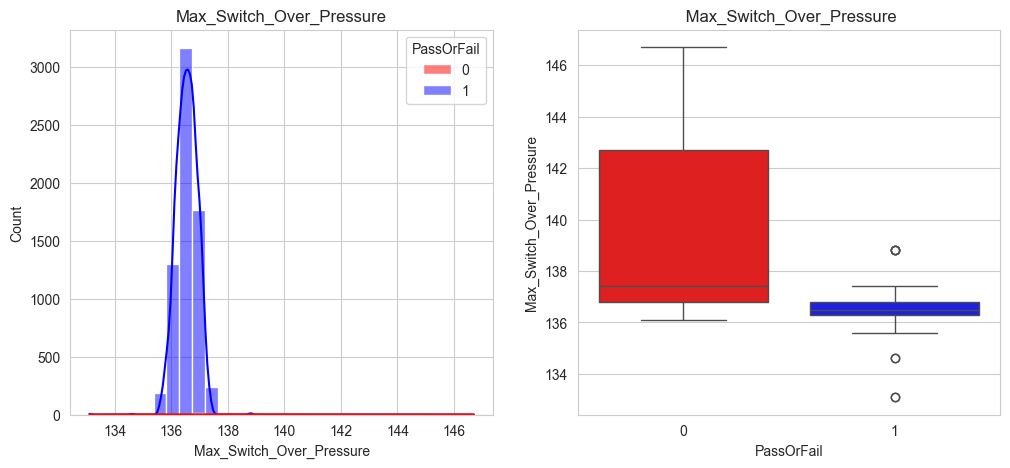

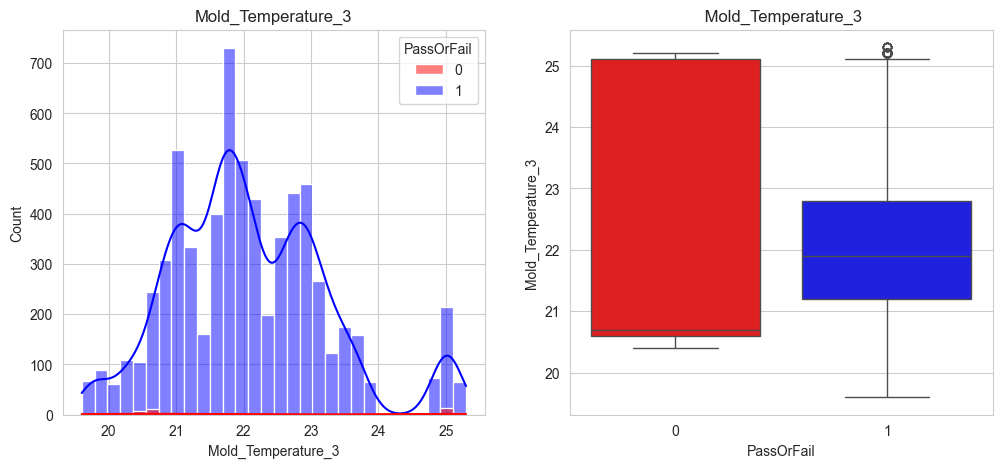

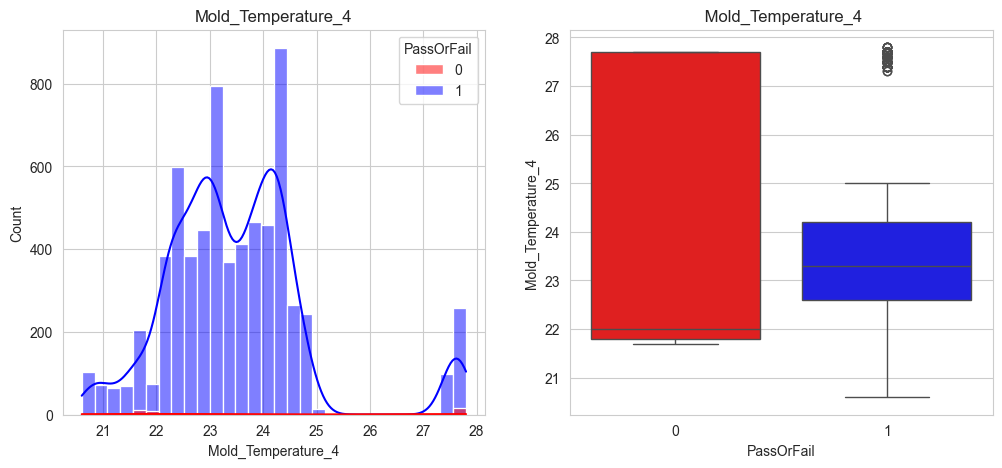

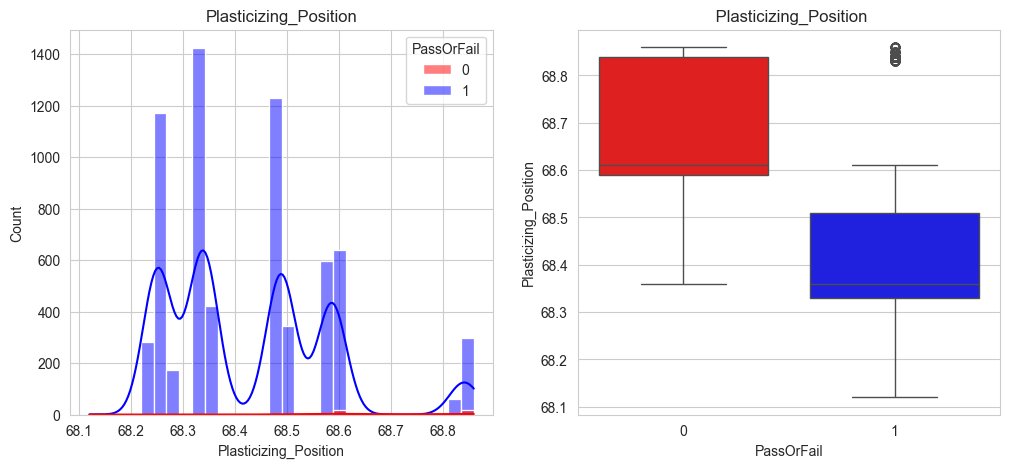

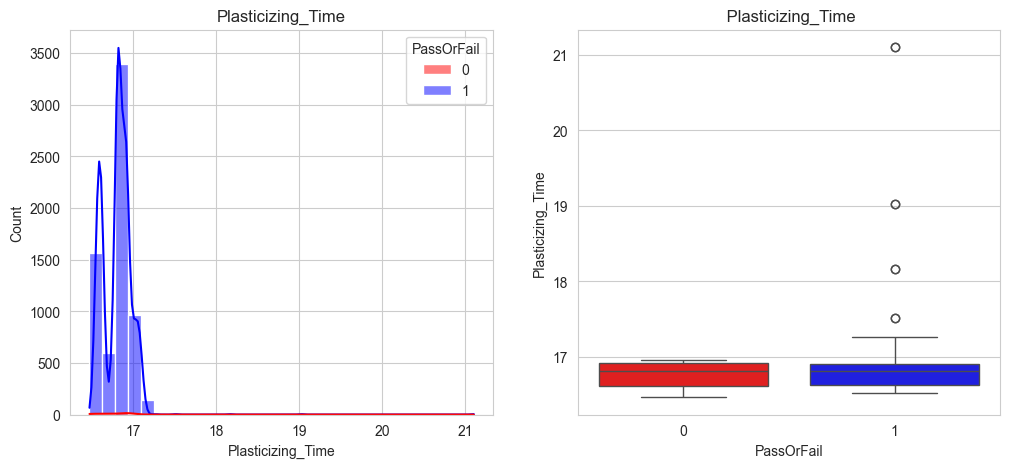

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 스타일 설정
sns.set_style("whitegrid")

# CN7 데이터의 수치형 변수 목록
numeric_columns = cn7.columns.difference(['PassOrFail'])

# 히스토그램 & 박스플롯 시각화 함수 정의
def plot_histogram_and_boxplot(data, target_column):
    for column in numeric_columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # 히스토그램
        sns.histplot(data, x=column, hue=target_column, bins=30, kde=True,
                     palette=["red", "blue"], ax=axes[0])
        axes[0].set_title(f'{column}')

        # 박스플롯 (hue 추가 및 dodge=False 설정)
        sns.boxplot(x=target_column, y=column, data=data, hue=target_column, 
                    dodge=False, palette=["red", "blue"], ax=axes[1], legend=False)
        axes[1].set_title(f' {column}')

        plt.show()

# 시각화 실행
plot_histogram_and_boxplot(cn7, 'PassOrFail')

In [8]:
cn7.columns

Index(['PassOrFail', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Plasticizing_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

In [12]:
cn7_u = cn7[cn7["Average_Screw_RPM"] > 200]
cn7_d = cn7[cn7["Average_Screw_RPM"] < 200]

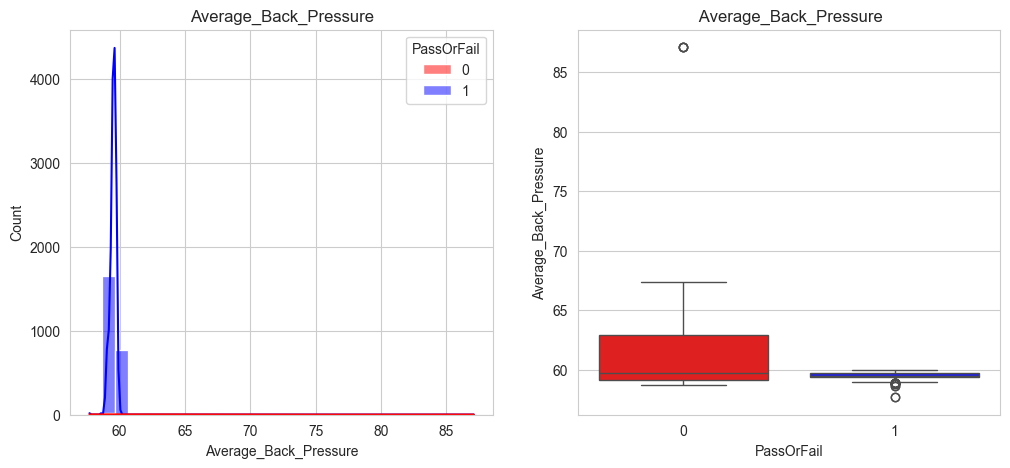

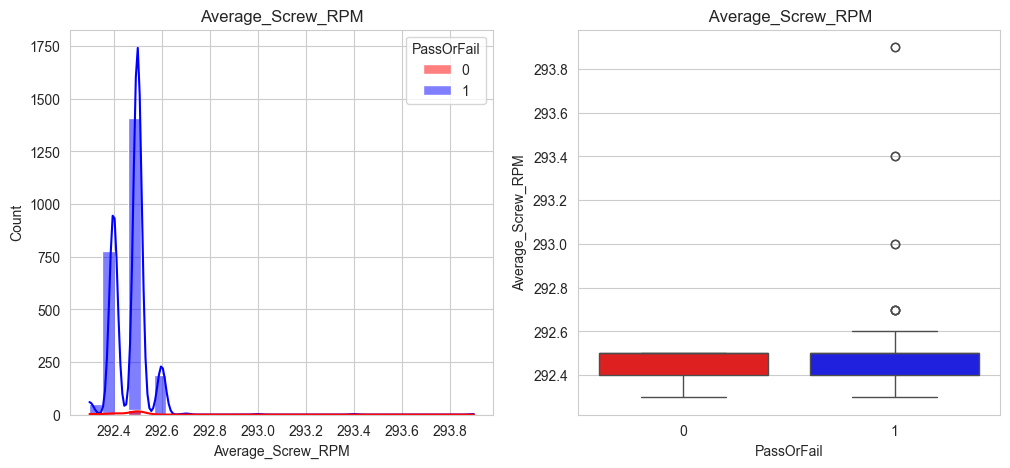

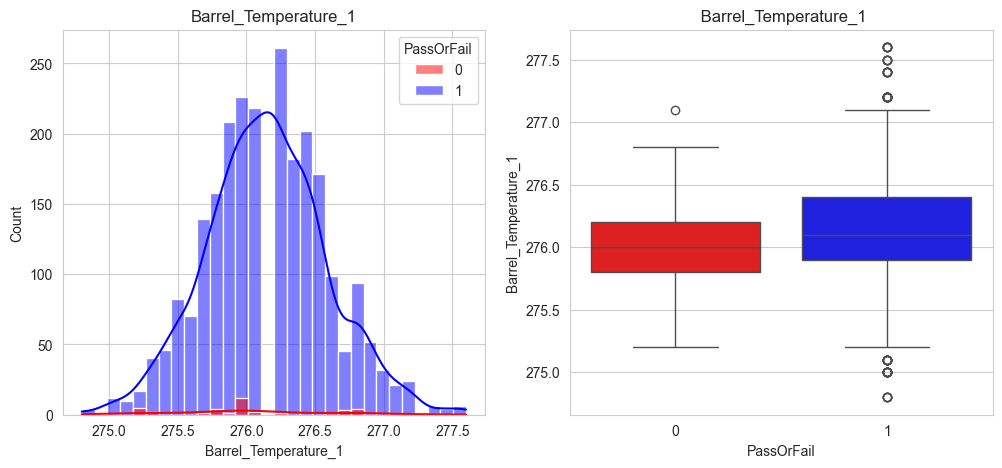

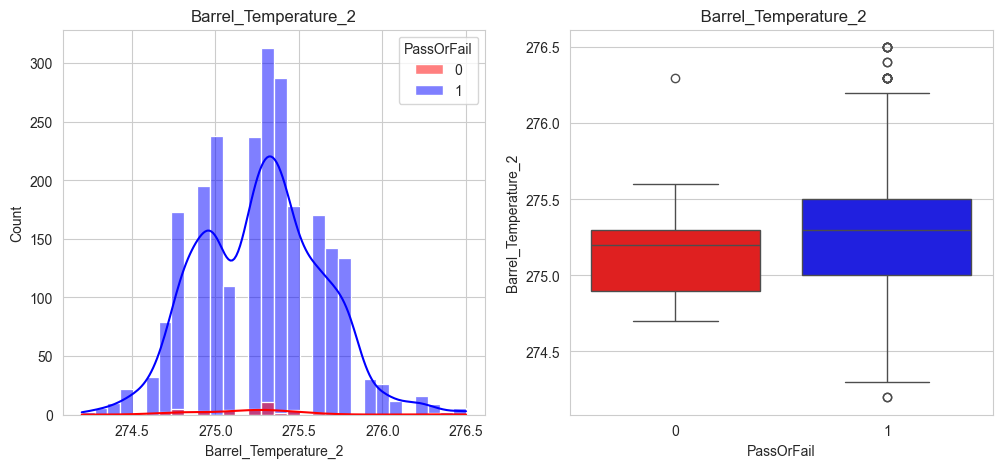

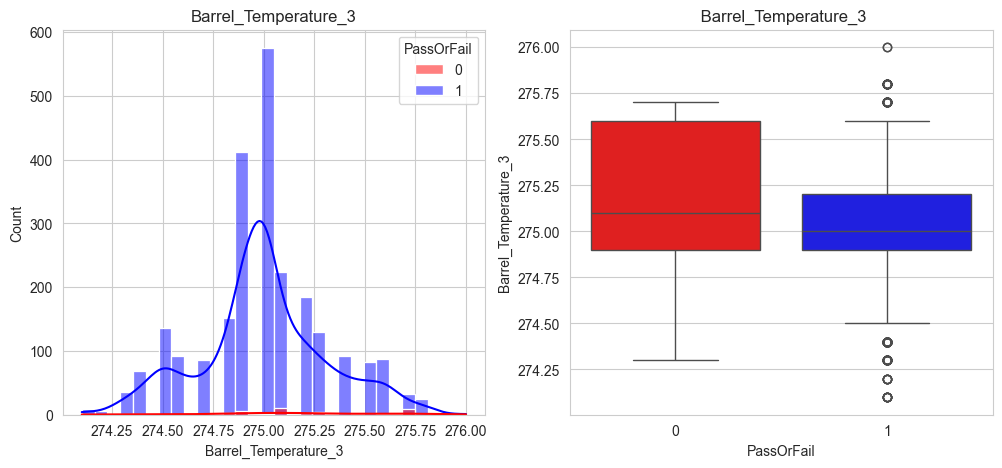

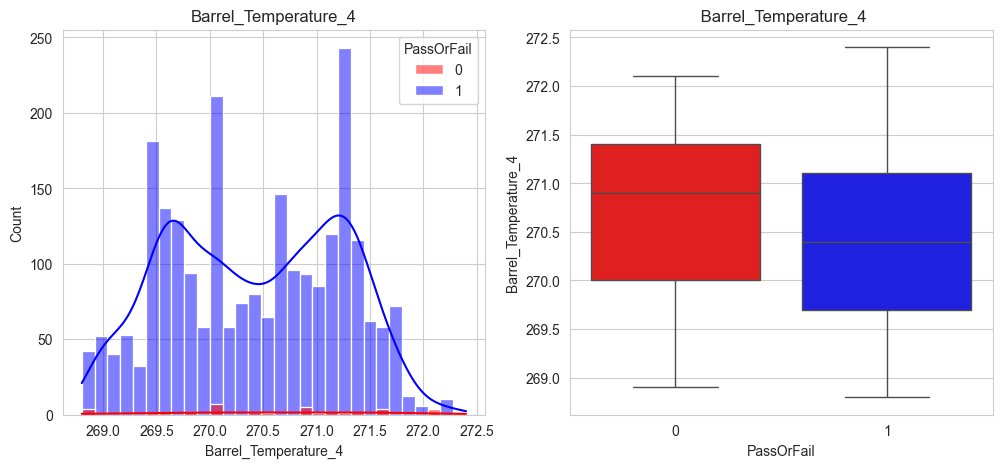

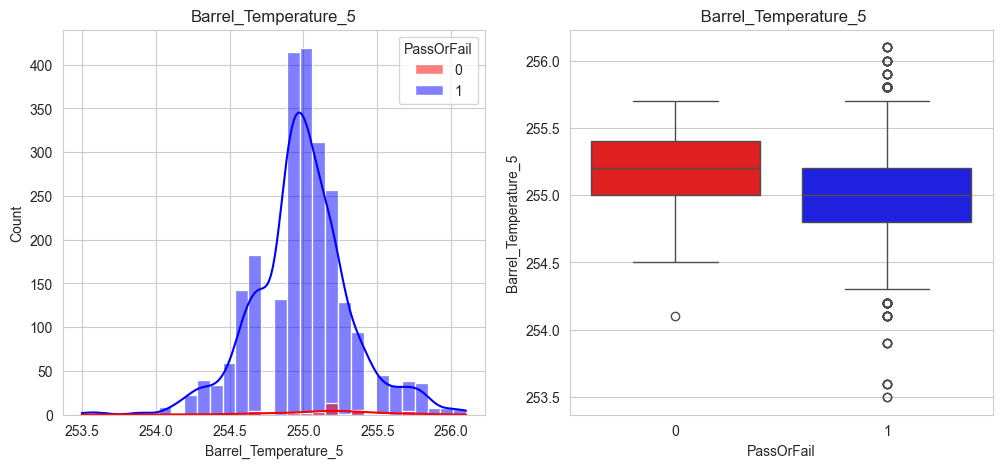

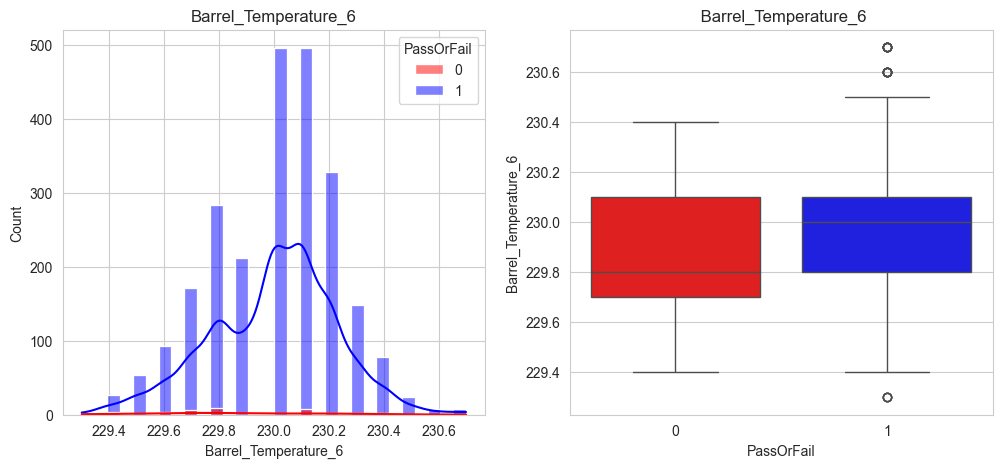

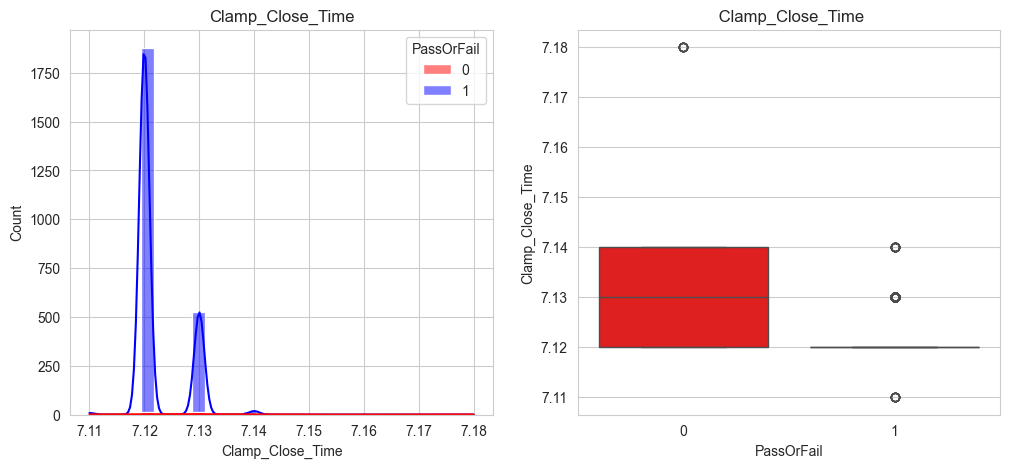

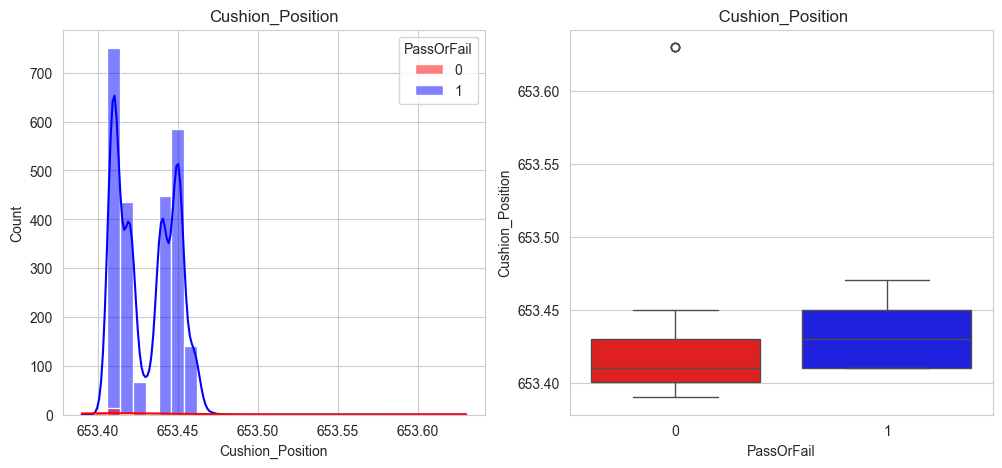

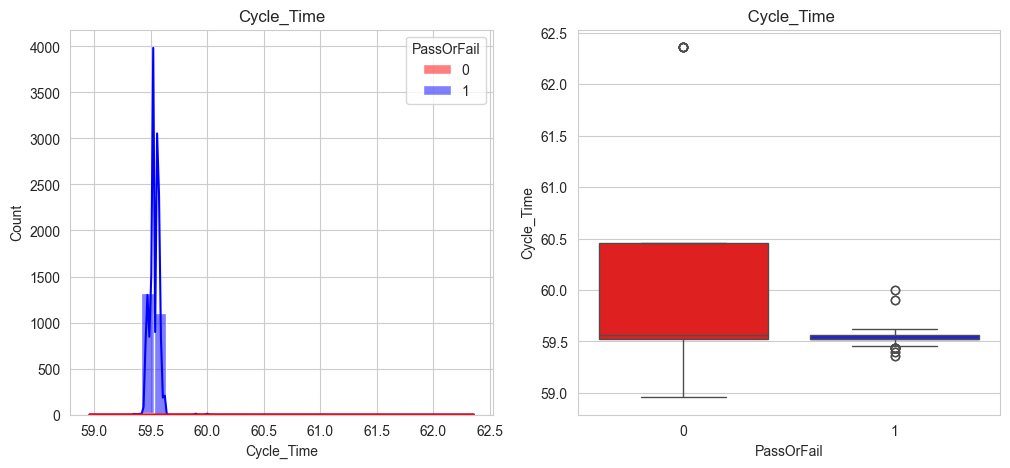

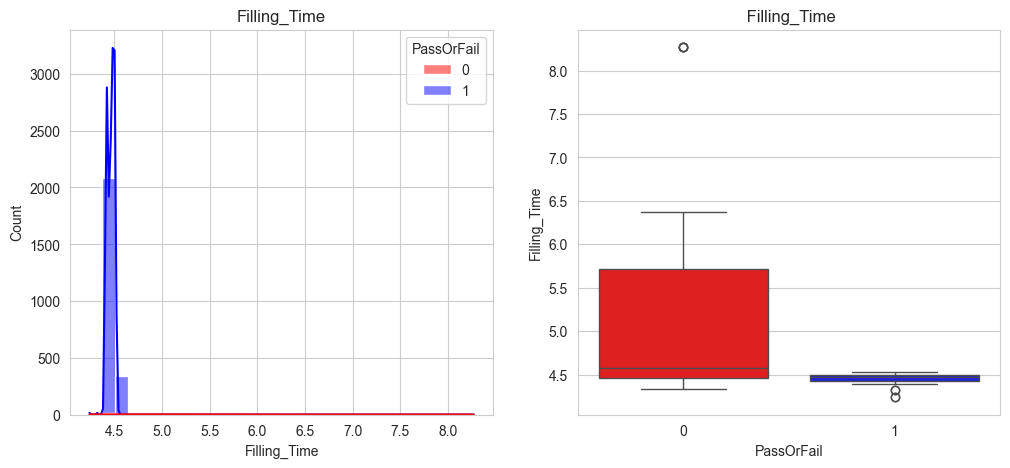

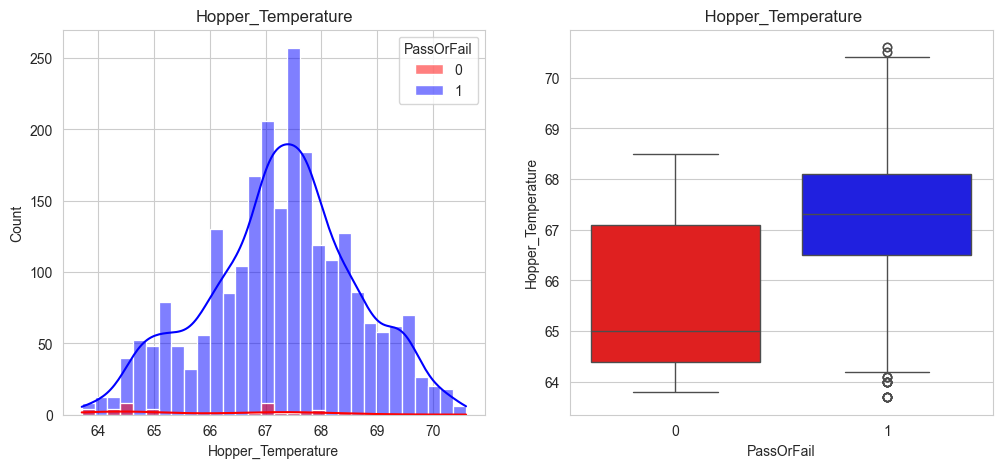

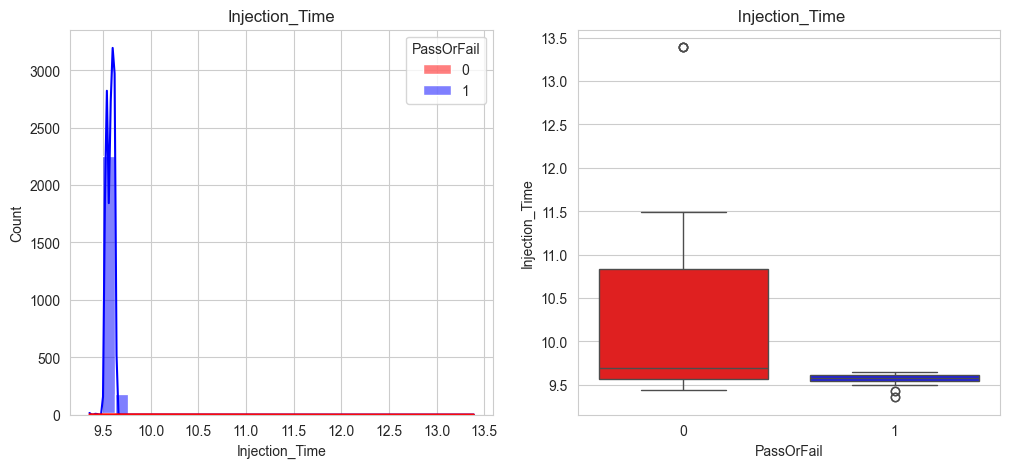

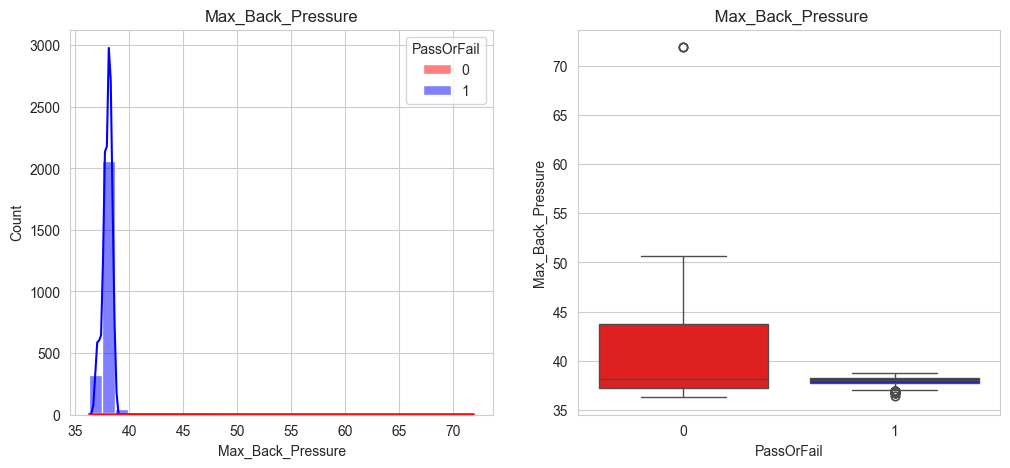

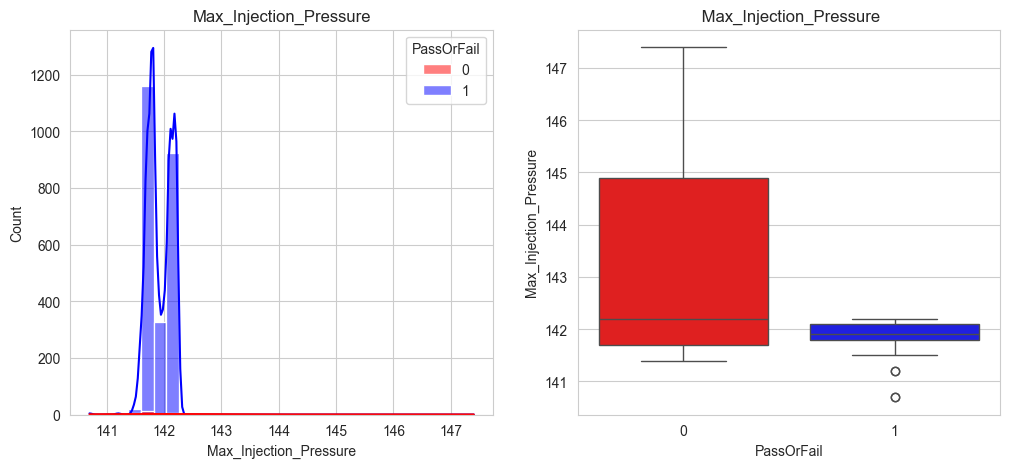

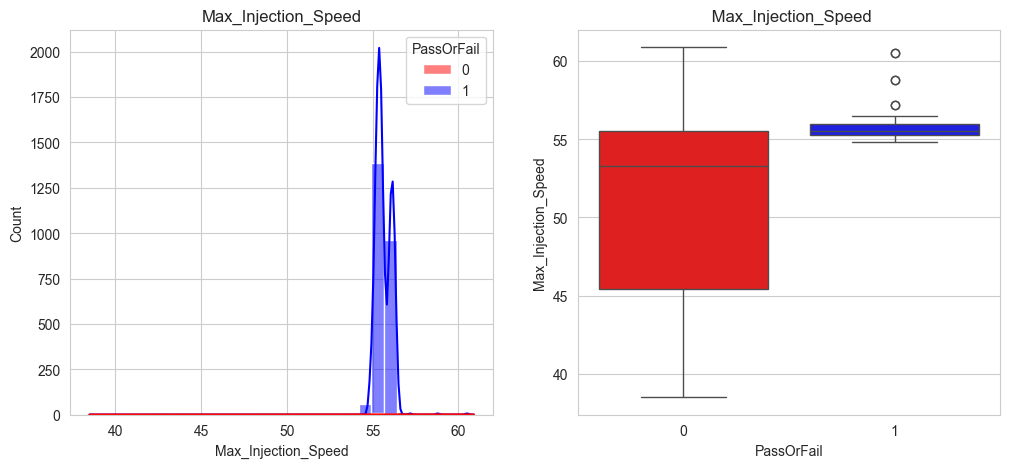

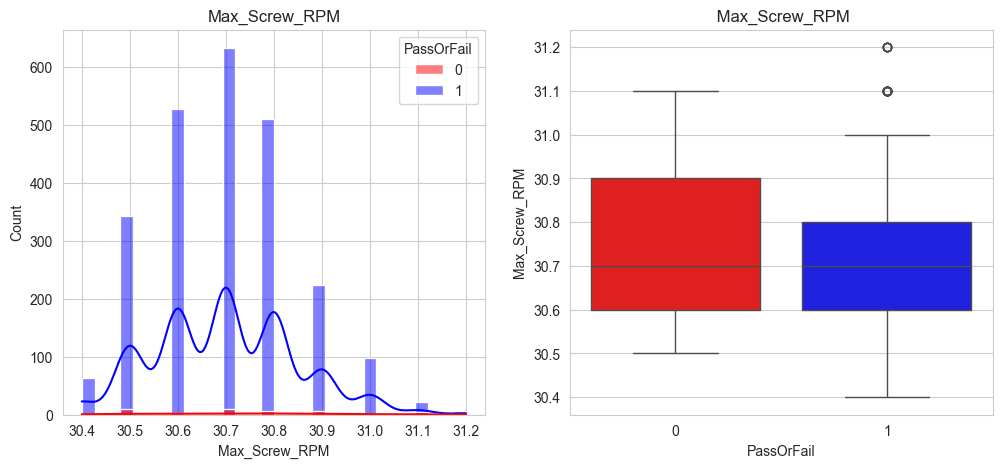

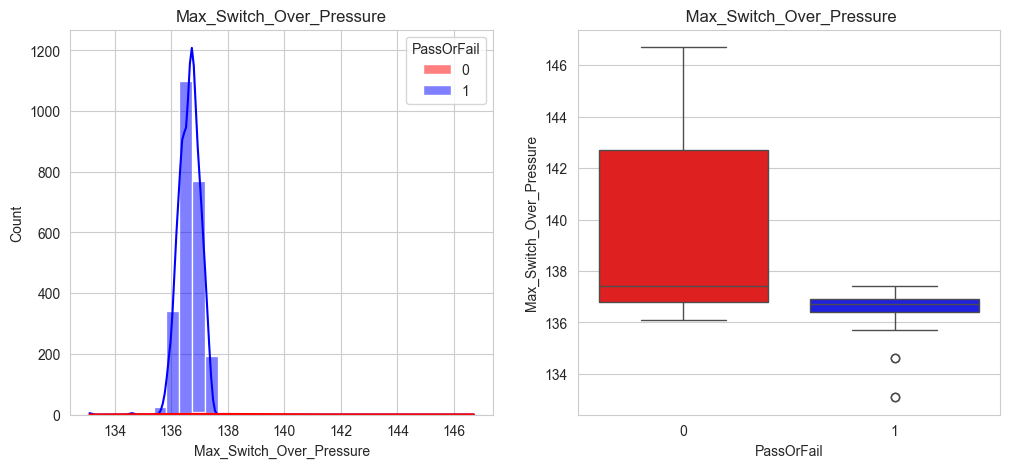

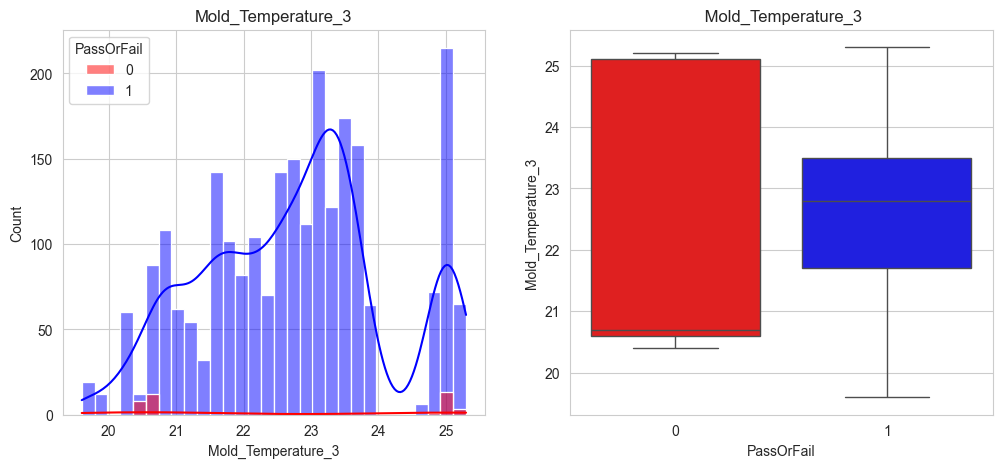

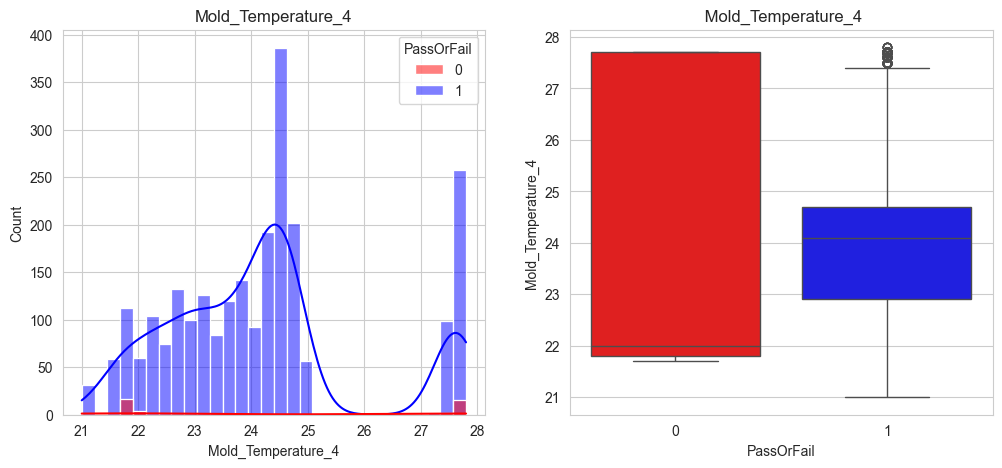

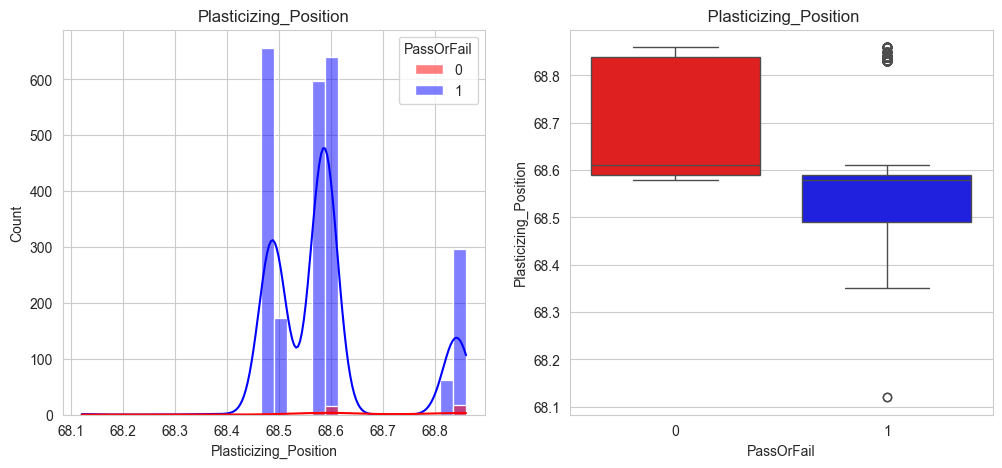

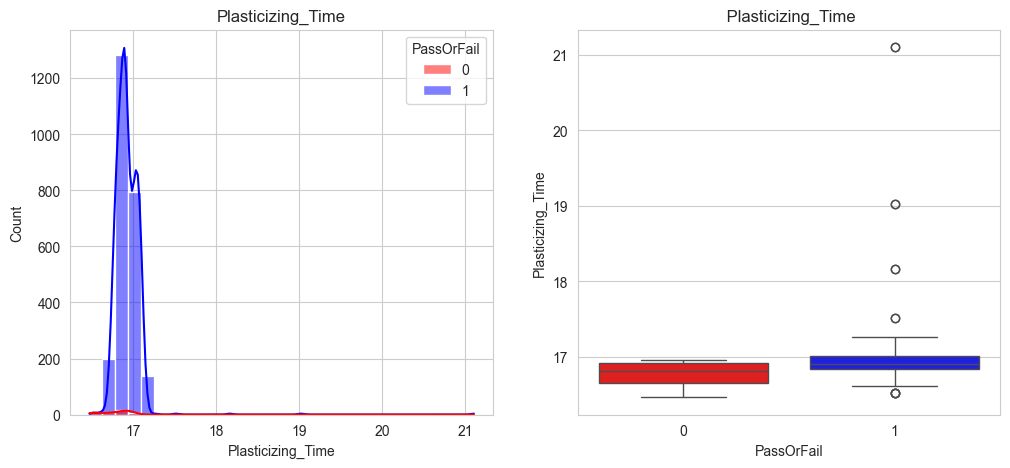

In [13]:
plot_histogram_and_boxplot(cn7_u, 'PassOrFail')